<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создадим-PipeLine" data-toc-modified-id="Создадим-PipeLine-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создадим PipeLine</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
!pip install scikit-learn==1.2.2 -q

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from time import time


# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder,  StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import mean_squared_error

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score, TimeSeriesSplit

# загружаем нужные модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

RANDOM_STATE = 42
TEST_SIZE = 0.1
FIGSIZE = (18, 10)
ROLLING_MEAN_SIZE =24# данное значение было взято из логики того, что в дне 24 часа
tss = TimeSeriesSplit(n_splits = 3)

In [3]:
def df_info(df):
    
    """
    Данная ф-я выводит первичную информацию о датафрейме
    """
    
    
    df.info()
    skip = df.isna().sum()
    dup = df.duplicated().sum()
    
    return print('\n' ,'Информация о пропусках:', skip, sep = '\n'), print('\n' ,'Кол-во дубликатов:', dup, sep = '\n')

In [4]:
def make_features(data, rolling_mean_size):
    
    """
    Данная ф-я создает новые признаки для обучения моделей
    """
    
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

## Подготовка

In [5]:
try:
    data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col = 'datetime')
    data.sort_index(inplace=True) # Добавил сортировку по индексу сразу в начале,
                                  # чтобы дополнительно не проводить проверку is_monotonic
    print('Данные успешно загружены с репозитория!')
except:
    data = pd.read_csv('Downloads/taxi.csv', parse_dates=[0], index_col = 'datetime')
    data.sort_index(inplace=True)# Добавил сортировку по индексу сразу в начале,
                                 # чтобы дополнительно не проводить проверку is_monotonic
    print('Данные успешно загружены с локального компьютера!')

Данные успешно загружены с репозитория!


In [6]:
data.head(15)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [7]:
df_info(data)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Информация о пропусках:
num_orders    0
dtype: int64


Кол-во дубликатов:
26415


(None, None)

Выполним ресемплирование по одному часу.

In [8]:
data = data.resample('1H').sum()

In [9]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


Так же предлагаю определить границы дат в выборке, чтобы не запутаться.

In [10]:
print(f'Минимальная дата {data.index.min()}', f'Максимальная дата: {data.index.max()}', sep = '\n')

Минимальная дата 2018-03-01 00:00:00
Максимальная дата: 2018-08-31 23:00:00


Выборка готова к анализу.

## Анализ

Построю общий график временного ряда

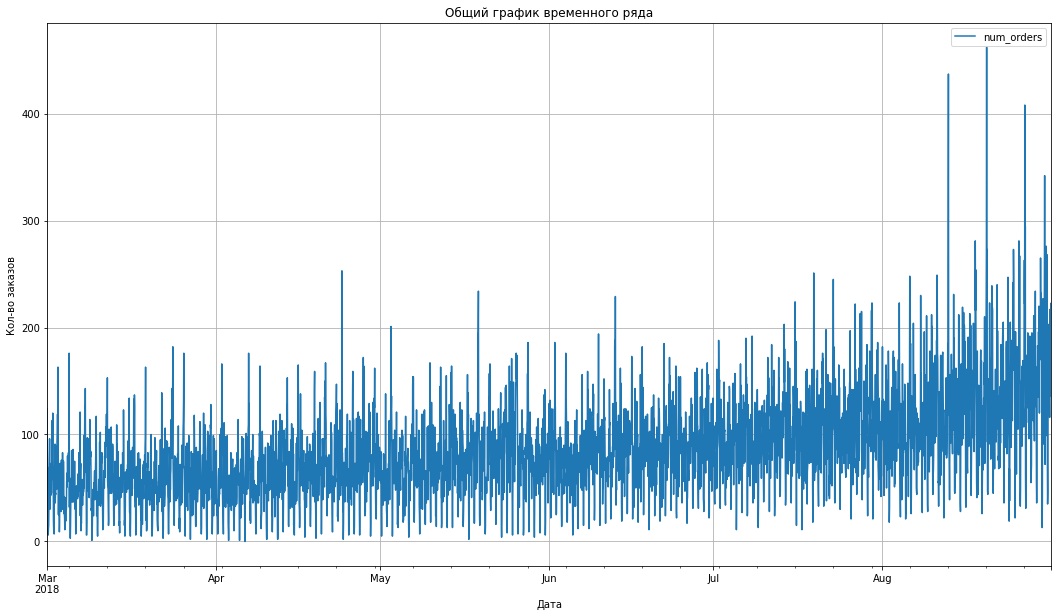

In [11]:
data.plot(figsize=FIGSIZE)
plt.title('Общий график временного ряда')
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')
plt.grid(True) 
plt.show()

Для анализа он плохо подойдет. 

Проведем ресемплирование на меньший промежуток дат для более подробного рассмотрения.

После построим график для скользящего среднего.

In [12]:
data_r = data['2018-08-01':'2018-08-31'].resample('1H').sum()

data_r['rolling_mean'] = data.shift().rolling(7).mean()

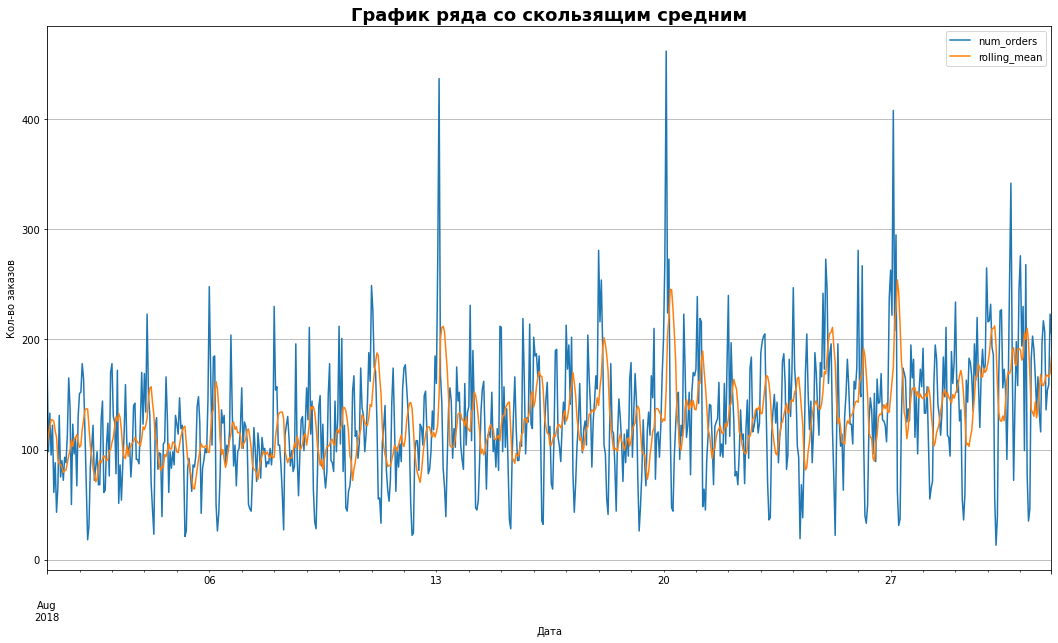

In [13]:
data_r.plot(figsize = FIGSIZE)
plt.title('График ряда со скользящим средним', fontweight='bold', fontsize=18)
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')
plt.grid(True) 
plt.show()

Данные о средних значениях получены. 

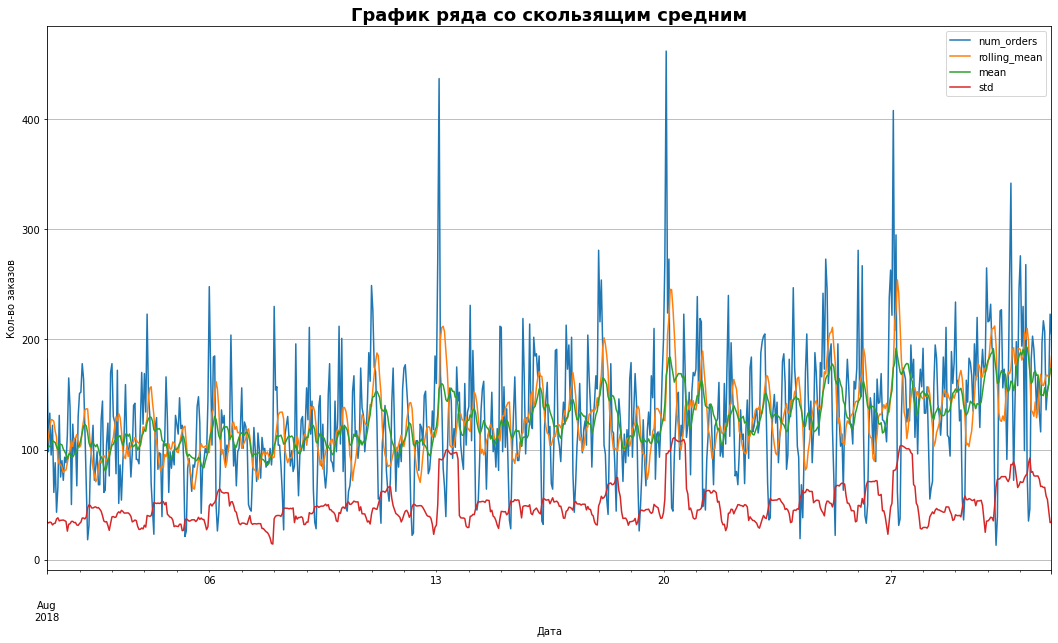

In [14]:
data_r['mean'] = data['num_orders'].rolling(15).mean()
data_r['std'] = data['num_orders'].rolling(15).std()
data_r.plot(figsize=FIGSIZE)
plt.grid(True) 
plt.title('График ряда со скользящим средним', fontweight='bold', fontsize=18)
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')
plt.show()

На данном графике наблюдаем явное изменение дисперсии, поэтому с уверенностью можно сказать, что данный временный ряд является нестационарным.

Теперь предлагаю рассмотреть графики тренда, сезонности(возьмем небольшой промежуток для большей наглядности) и распределение остатков.

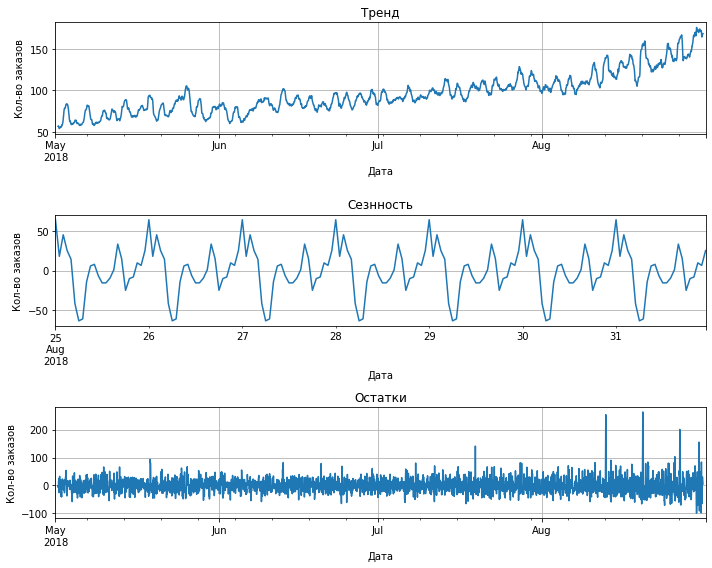

In [15]:
data_r = data['2018-05':'2018-08'].resample('1H').sum()

decomposed = seasonal_decompose(data_r)

plt.figure(figsize=(10, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')
plt.title('Тренд')
plt.grid(True)
plt.subplot(312)
decomposed.seasonal.tail(24*7).plot(ax=plt.gca())
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')
plt.title('Сезнность')
plt.grid(True) 
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')
plt.title('Остатки')
plt.tight_layout()
plt.grid(True) 
plt.show()

1) В первом графике наблюдаем восходящую линию тренда. Можно предположить, что сервис заказа такси набирает популярность и кол-во заказов растет. Чтобы связать увеличение тренда с сезонностью необходимо больше вводных.

2) Во втором графике видим четкую линию сезонности по дням! Предлагаю ниже рассмотреть несколько дней для наглядности. 

3) Шум (или остатки) тоже выглядит вполне логично. С повышением линии тренда, видим закономерно возросший шум в данных.

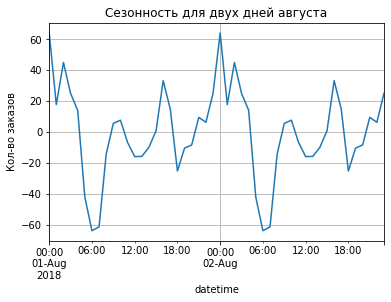

In [16]:
plt.title('Сезонность для двух дней августа')
decomposed.seasonal['2018-08-01':'2018-08-02'].plot()
plt.ylabel('Кол-во заказов')
plt.grid(True) 
plt.show()

Да, изначальное утверждение верное. В 6 утра мы наблюдаем "плато" минимума заказов, которое ближе к утра возрастает. Далее видим пик ближе к 17-00, после резки спад. И уже пик максимального кол-ва заказов приходится на 12 часов ночи. И такую картину мы будет наблюдать каждый день. 

Думаю, что подобную закономерность можно связать с регулярным расписанием самолетов, которые прилетают в данные промежутки времени.

**Вывод**

Анализ данных проведен успешно. Графики временного ряда(тренды, сезонность и т.д.) построены.
* Наблюдаем увеличение дисперсии. 
* Выявили явную дневную сезонную закономерность.
* Ряд не может являться стационарным, т.к. имеется явно растущий тренд.

По всем рассмотренным мной графикам и закономерностям, я хочу выделить признаки, которые на мой взгляд будут полезны в обучении модели: 
- день
- день недели
- месяц

Можно приступать к обучению моделей.

## Обучение

Подготовим признаки для обучения.

In [17]:
taxi = data.copy()
make_features(taxi, ROLLING_MEAN_SIZE)

In [18]:
taxi.head(10)

,num_orders,day,dayofweek,hour,rolling_mean
datetime,,,,,
2018-03-01 00:00:00,124,1,3,0,NaN
2018-03-01 01:00:00,85,1,3,1,NaN
2018-03-01 02:00:00,71,1,3,2,NaN
2018-03-01 03:00:00,66,1,3,3,NaN
2018-03-01 04:00:00,43,1,3,4,NaN
2018-03-01 05:00:00,6,1,3,5,NaN
2018-03-01 06:00:00,12,1,3,6,NaN
2018-03-01 07:00:00,15,1,3,7,NaN
2018-03-01 08:00:00,34,1,3,8,NaN


In [19]:
X = taxi.drop('num_orders', axis = 1)
y = taxi['num_orders']

In [20]:
cat_columns = ['day', 'dayofweek', 'hour']

num_columns = ['rolling_mean']

target = 'num_orders'

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=TEST_SIZE, random_state=RANDOM_STATE)




In [22]:
X_train.shape

(3974, 4)

In [23]:
X_test.shape

(442, 4)

### Создадим PipeLine

In [24]:
# Добавил отдельный пайплайн для линейной регрессии

scal_pipe = Pipeline(
    [
        ('simple_imputer_scal', SimpleImputer(strategy='mean', missing_values=np.nan)),
        ('scal', StandardScaler())
    ]
)

ohe_pipe = Pipeline(
    [
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

lr_preprocessor = ColumnTransformer(
    transformers=[
        ('scal', scal_pipe, num_columns),
        ('ohe', ohe_pipe, cat_columns)
    ]
)

In [25]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='mean')),
     ('ord',  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='mean'))
    ]
)

data_preprocessor = ColumnTransformer(
    transformers=[
        ('scal', scal_pipe, num_columns),
        ('ord', ord_pipe, cat_columns),
    ]
)

### LinearRegression

In [26]:
lr_pipe = Pipeline(
    [
        ('preprocessor', lr_preprocessor),
        ('model', LinearRegression())
    ]
)

In [27]:
%%time

fit_start_lr = time()
lr_pipe.fit(X_train, y_train)
fit_end_lr = time()

CPU times: user 43.2 ms, sys: 21.5 ms, total: 64.6 ms
Wall time: 26.1 ms


In [28]:
result_lr = round(abs(cross_val_score(lr_pipe, X_train, y_train, cv=tss, scoring='neg_mean_squared_error').mean()) ** 0.5, 2)

In [29]:
print('RMSE для LinearRegression через кроссвалидацию равна', result_lr)

RMSE для LinearRegression через кроссвалидацию равна 29.16


### LightGBM

In [30]:
lgbm_pipe = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('model', LGBMRegressor(random_state=RANDOM_STATE))
    ]
)

In [31]:
lgbm_params = {
    'model__n_estimators': range(200, 500),
    'model__max_depth': range(2, 8),
    'model__num_leaves': range(4, 16)
}

In [32]:
lgbm_random_search = RandomizedSearchCV(
    lgbm_pipe,
    lgbm_params,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    cv=tss,
    random_state=RANDOM_STATE
)

In [33]:
%%time

lgbm_start_fit = time()

lgbm_random_search.fit(X_train, y_train)

lgbm_end_fit = time()

CPU times: user 21 s, sys: 263 ms, total: 21.3 s
Wall time: 21.6 s


In [34]:
best_lgbm = lgbm_random_search.best_estimator_

In [35]:
result_lgbm = round(abs(lgbm_random_search.best_score_) ** 0.5, 2)

In [36]:
print('RMSE для LGBM на кроссвалидации равна', result_lgbm)

RMSE для LGBM на кроссвалидации равна 27.37


### DecisionTreeRegressor

In [37]:
dt_pipe= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('model', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ])

In [38]:
dt_params = {
    'model__min_samples_split': range(2, 10),
    'model__min_samples_leaf': range(1, 10),
    'model__max_depth': range(1, 9)
}

In [39]:
dt_random_search = RandomizedSearchCV(
    dt_pipe,
    dt_params,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    cv=tss,
    random_state=RANDOM_STATE
)

In [40]:
%%time

dt_start_fit = time()

dt_random_search.fit(X_train, y_train)

dt_end_fit = time()

CPU times: user 715 ms, sys: 2.89 ms, total: 718 ms
Wall time: 717 ms


In [41]:
dt_best = dt_random_search.best_estimator_

In [42]:
result_dt = round(abs(dt_random_search.best_score_) ** 0.5, 2)

In [43]:
print('RMSE для DecisionTreeRegressor на кроссвалидации равна', result_dt)

RMSE для DecisionTreeRegressor на кроссвалидации равна 29.35


## Тестирование

Пришло время для сверки результатов. Сделаю небольшую таблицу для их наглядности.

In [44]:
result_rmse = [['LinearRegression', result_lr, round(fit_end_lr-fit_start_lr, 3)],
          ['LightGBM', result_lgbm, round(lgbm_end_fit-lgbm_start_fit, 3)],
          ['DecisionTreeRegressor', result_dt, round(dt_end_fit-dt_start_fit, 3)]]
result_rmse= pd.DataFrame(result_rmse, columns=['Модель обучения','RMSE', 'Время обучения, сек'])
result_rmse = result_rmse.set_index('Модель обучения')
result_rmse.index.names = [None]
result_rmse

,RMSE,"Время обучения, сек"
LinearRegression,29.16,0.026
LightGBM,27.37,21.474
DecisionTreeRegressor,29.35,0.717


Очевидно, что в при кроссвалидации лучшая метрка RMSE оказалось у модели LightGBM. Значение RMSE значительно лучше, чем у остальных и скорость обучения модели на тренировачных данных показал себя хорошо. 

Попробуем сделать предсказание с помощью данной модели и посмотрим на итоговое значение RMSE.

In [45]:
pred_lgbm_test = best_lgbm.predict(X_test)

In [46]:
print('RMSE для LightGBM равняется', round(mean_squared_error(y_test, pred_lgbm_test) ** 0.5, 2))

RMSE для LightGBM равняется 47.41


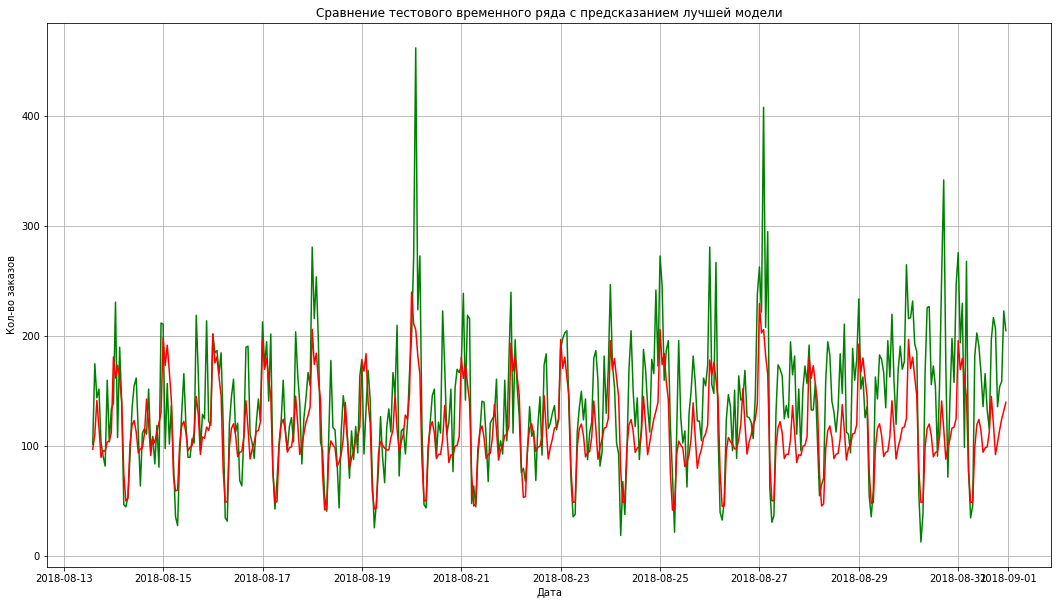

In [47]:
plt.figure(figsize=FIGSIZE)
plt.plot(y_test.index, 
         y_test, 
         'g-', 
         y_test.index, 
         pred_lgbm_test,
         'r-')
plt.title('Сравнение тестового временного ряда с предсказанием лучшей модели')
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')
plt.grid(True) 
plt.show()

Если сравнить показатели тестовой выборки с предсказаниями лучшей модели, то можно сделать вывод, что модель достаточно неплохо справляется со своей задачей. Явно видно, что закономерность пиков и спадов кол-ва заказов соблюдается. Но видно, что модель предсказывает меньшее кол-во заказов меньше фактического, особенно это заметно на пиковых значениях.

Проверим нашу модель на адекватность, с помощью создания модели DummyRegressor. 

In [48]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
dummy_pred = dummy_regr.predict(X_test)
print('RMSE для DummyRegressor равняется', round(mean_squared_error(y_test, dummy_pred) ** 0.5, 2))
print('R2 для DummyRegressor равняется',dummy_regr.score(X_test, y_test))

RMSE для DummyRegressor равняется 84.74
R2 для DummyRegressor равняется -1.094939044981377


Показатель RMSE у DummyRegressor составляет 84.74, что совсем никак не соответствует условям нашей задачи и хуже показетеля нашей лучшей модели почти в два раза. 

Отрицательный  показатель метрики R² означает, что средние значения всегда будут лучше прогнозируемых данной моделью

**Вывод**

Для модели LightGBM значение метрики RMSE 47.41. При условии, что тестовая выборка составляет всего 10% от нашего датафрейма, данный показатель целевой метрики удолетворяет условию задачи.

## Общий вывод

После проделанной работы хочется подвести итоги и тезисно обозначить основные шаги и результаты.

1) Мною был успешно загружен файл с данными `taxi.csv` и обработан в соответствии с поставленной задачей
    * За индекс была взята дата заказа
    * Данные были отсортированы по индексу
    * Таблица была семплирована по одному часу.


2) Был проведен анализ временных рядом. 
    * Проанализировал тренд. Заметил, что наблюадется явное возрастание тренда.
    * Проанализирова сезонность. Выявил явную дневную закономерность сезонности.
    * Проанализировал остатки. Всплески остатков соответсвовали возрастанию тренда.
    * Обозначил, что ряд не может являться стационарным, т.к. имеется явно растущий тренд.
    * Выделил основные метрики, которые мне буду необходимы в процессе обучения моделей.

3) Мною было обученр три модели
    * LinearRegression
    * LightGBMR
    * DecisionTreeRegressor
    
Для каждой была посчитана метрика RMSE посредством кросс-валидации. По итогам анализа была выбрана лучшая модель, ей оказалось LightGBMR. Она показал хорошие результаты по времени обучения и имела лучший результата RMSE.

4) С помощью данной модели я смог сделать предсказание на тестовой выборке и получил удолетворяющее значение метрики RMSE 47.41. Это значение соответствует условиям моей задачи. Так же провел сравнение предсказаний данной модели с результатами обучения dummy-модели, что помогло лишний раз убедиться в работоспособность выбранной модели.